<a href="https://colab.research.google.com/github/Akechi1412/Phishing-Website-Detection/blob/main/app/notebooks/training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Train Phishing Webpage Detection Model**

## **Connect to Drive and Github responsitory**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Github
%cd Phishing-Website-Detection/app
!git config --global user.email 'nguyenphong10042002@gmail.com'
!git config --global user.name 'Akechi1412'
!git fetch origin
!git reset --hard origin/main

/content/drive/MyDrive/Github
/content/drive/MyDrive/Github/Phishing-Website-Detection/app
Updating files: 100% (73/73), done.
HEAD is now at 648e4fd Merge branch 'main' of https://github.com/Akechi1412/Phishing-Website-Detection


## **Load dataset**

In [3]:
import h5py
import tensorflow as tf

In [4]:
def load_dataset(file_path, batch_size=1024):
    with h5py.File(file_path, 'r') as f:
        url_data = f['url']
        adjacency_data = f['adjacency']
        feature_data = f['feature']
        label_data = f['label']

        num_samples = label_data.shape[0]

        dataset = tf.data.Dataset.from_tensor_slices((
            (
                tf.convert_to_tensor(url_data, dtype=tf.int32),
                tf.convert_to_tensor(adjacency_data, dtype=tf.float32),
                tf.convert_to_tensor(feature_data, dtype=tf.float32)
            ),
            tf.convert_to_tensor(label_data, dtype=tf.int32)
        ))

    dataset = dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

    return dataset

## **Create models functions**

### **Create URL model using Transformer Neutral Network**

In [5]:
!pip install spektral

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.1/140.1 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 58.3 MB/s eta 0:00:00


In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, regularizers
from utils.layers import PositionalEmbedding, TransformerEncoder

In [ ]:
def create_url_model(vocab_size, max_words, embed_dim,
                     num_heads, intermediate_dim,
                     dropout=0.1, num_transformer_layers=1):
    inputs = keras.Input(shape=(max_words,), dtype=tf.int32)
    x = PositionalEmbedding(max_words, vocab_size, embed_dim)(inputs)
    for _ in range(num_transformer_layers):
        x = TransformerEncoder(embed_dim, num_heads, intermediate_dim)(x)
        x = layers.Dropout(dropout)(x)
    x = layers.GlobalAveragePooling1D()(x)
    url_model = keras.Model(inputs=inputs, outputs=x)

    return url_model

### **Create HTML model using Graph Convolution Network**

In [7]:
from spektral.layers import GCNConv, GlobalSumPool
from utils.layers import GCN

In [ ]:
def create_html_model(max_nodes, feature_dim, gcn_units,
                      dropout=0.1, num_gcn_layers=1):
    inputs_adj = keras.Input(shape=(max_nodes, max_nodes), dtype=tf.float32)
    inputs_feat = keras.Input(shape=(max_nodes, feature_dim), dtype=tf.float32)

    x = inputs_feat
    for _ in range(num_gcn_layers):
        x = GCN(gcn_units, activation='relu')([x, inputs_adj])
        x = layers.Dropout(dropout)(x)
    x = GlobalSumPool()(x)
    html_model = keras.Model(inputs=[inputs_adj, inputs_feat], outputs=x)

    return html_model

### **Create full model**

In [ ]:
def create_full_model(vocab_size, max_words, dropout, embed_dim,
                      num_heads, intermediate_dim, num_transformer_layers,
                      max_nodes, feature_dim, gcn_units,
                      num_gcn_layers, dense_dim, l2_reg):
    # URL Model
    url_model = create_url_model(vocab_size, max_words, embed_dim, num_heads,
                                 intermediate_dim, dropout, num_transformer_layers)

    # HTML Model
    html_model = create_html_model(max_nodes, feature_dim, gcn_units,
                                   dropout, num_gcn_layers)

    # Inputs
    url_inputs = keras.Input(shape=(max_words,), dtype=tf.int32)
    adj_inputs = keras.Input(shape=(max_nodes, max_nodes), dtype=tf.float64)
    feat_inputs = keras.Input(shape=(max_nodes, feature_dim), dtype=tf.float64)

    # Outputs from both models
    url_output = url_model(url_inputs)  # (None, embed_dim)
    html_output = html_model([adj_inputs, feat_inputs])  # (None, gcn_units)

    # Concatenate the outputs (both are 2D now)
    combined = layers.Concatenate()([url_output, html_output])  # (None, embed_dim + gcn_units)

    # Final layers
    x = layers.Dense(dense_dim,
                     activation='relu',
                     kernel_regularizer=regularizers.l2(l2_reg))(combined)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(dense_dim//2,
                     activation='relu',
                     kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = layers.Dropout(dropout)(x)

    outputs = layers.Dense(1, activation='sigmoid')(x)

    full_model = keras.Model(inputs=[url_inputs, adj_inputs, feat_inputs], outputs=outputs)
    return full_model

## **Train model**

In [ ]:
vocab_size = 6000
max_words = 50
max_nodes = 600
feature_dim = 3

train_dataset = load_dataset('data/train.h5', batch_size=1020)
val_dataset = load_dataset('data/val.h5', batch_size=1020)

model = create_full_model(vocab_size=vocab_size,
                          max_words=max_words,
                          dropout=0.3,
                          embed_dim=128,
                          num_heads=8,
                          intermediate_dim=128,
                          num_transformer_layers=2,
                          max_nodes=max_nodes,
                          feature_dim=feature_dim,
                          gcn_units=128,
                          num_gcn_layers=2,
                          dense_dim=128,
                          l2_reg=5e-4)

model.summary()

optimizer = keras.optimizers.Adam(learning_rate=1e-3)
focal_loss = keras.losses.BinaryFocalCrossentropy(gamma=2)
metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
model.compile(optimizer=optimizer, loss=focal_loss, metrics=metrics)

checkpoint_filepath = 'models/best_model.keras'

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

history = model.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs=100,
                    callbacks=[checkpoint_callback, early_stopping])

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 50)]                 0         []                            
                                                                                                  
 input_5 (InputLayer)        [(None, 600, 600)]           0         []                            
                                                                                                  
 input_6 (InputLayer)        [(None, 600, 3)]             0         []                            
                                                                                                  
 model (Functional)          (None, 128)                  1896448   ['input_4[0][0]']             
                                                                                            

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

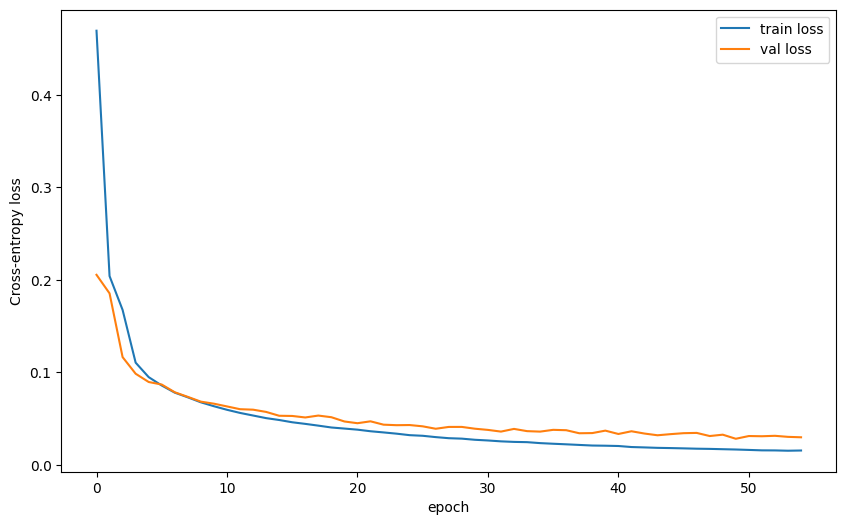

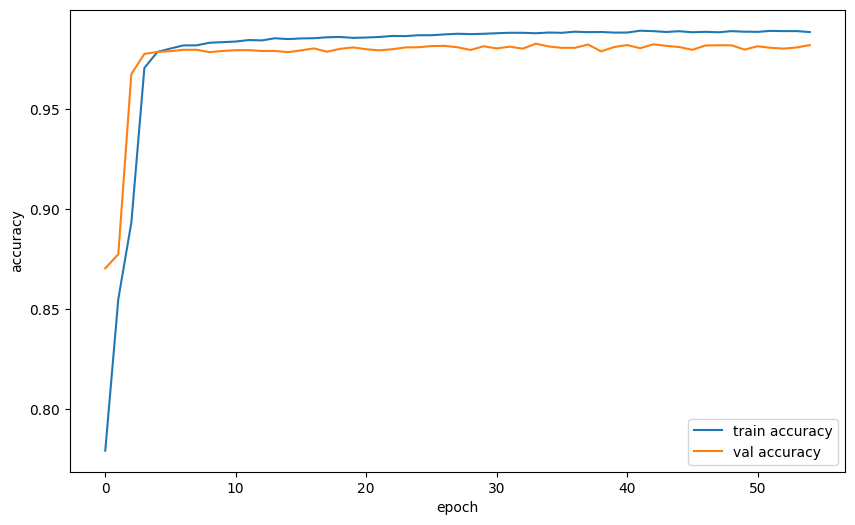

In [ ]:
# Plot history loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('epoch')
plt.ylabel('Cross-entropy loss')
plt.legend()
plt.show()

# Plot history accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

## **Test and evaluate model**

In [8]:
best_model = keras.models.load_model(
    'models/best_model.keras',
    custom_objects={'TransformerEncoder': TransformerEncoder,
                    'PositionalEmbedding': PositionalEmbedding,
                    'GCNConv': GCNConv,
                    'GlobalSumPool': GlobalSumPool,
                    'GCN': GCN})

In [ ]:
best_model.save('models/best_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [9]:
from sklearn.metrics import classification_report, confusion_matrix

In [11]:
test_dataset = load_dataset('data/val.h5', batch_size=1020)

y_pred_prob = best_model.predict(test_dataset)
y_pred = (y_pred_prob > 0.5).astype(int)

label_test = tf.concat([y for x, y in test_dataset], axis=0).numpy()
print(classification_report(label_test, y_pred, digits=4))

10/10 [==============================] - 39s 3s/step
              precision    recall  f1-score   support

           0     0.9787    0.9810    0.9798      5100
           1     0.9809    0.9786    0.9798      5100

    accuracy                         0.9798     10200
   macro avg     0.9798    0.9798    0.9798     10200
weighted avg     0.9798    0.9798    0.9798     10200



In [12]:
import numpy as np

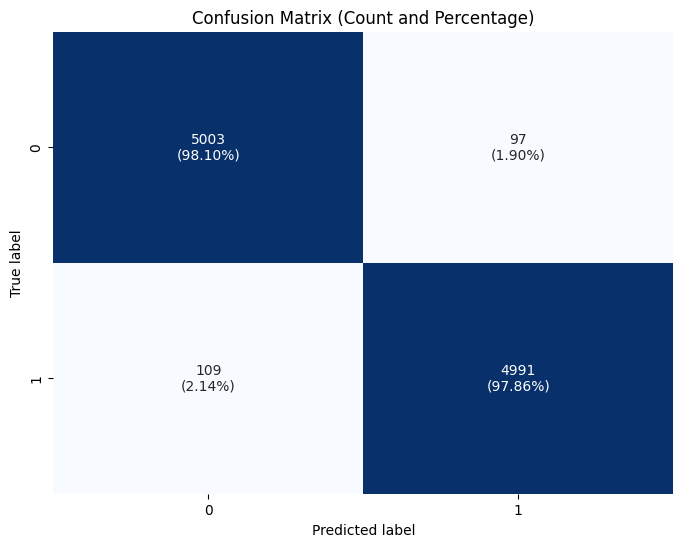

In [15]:
cm = confusion_matrix(label_test, y_pred)
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

labels = [[f'{int(count)}\n({percentage:.2%})'
           for count, percentage in zip(row_count, row_percentage)]
           for row_count, row_percentage in zip(cm, cm_percentage)]

plt.figure(figsize=(8, 6))
sns.heatmap(cm_percentage, annot=labels, fmt='', cmap='Blues', cbar=False)
plt.title('Confusion Matrix (Count and Percentage)')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()